In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import fetch_olivetti_faces 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score

np.random.seed(42)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 9)

# Etude 1 - Clustering Olivetti Dataset

The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set. Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter). Visualize the clusters: do you see similar faces in each cluster?

In [ ]:
olivetti_faces = fetch_olivetti_faces()

In [ ]:
X, y, images = olivetti_faces.data, olivetti_faces.target, olivetti_faces.images

Let's first visualize some random images from the dataset.

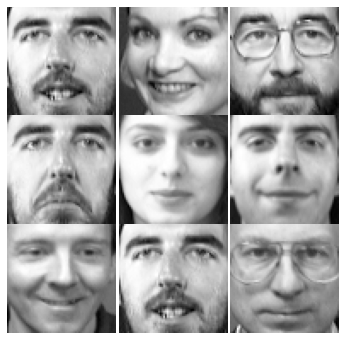

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(9):
    fig.add_subplot(3,3,i+1)
    image_show = images[np.random.randint(0, 400), : ]
    plt.imshow(image_show, cmap = mpl.cm.gray)
    plt.axis("off")

Not we split the dataset into a train, test, and validation set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

## Visualize Data

First let's visualize the data using the PCA + t-SNE method. Then we will try to determine the approximate number of clusters using KMeans.

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

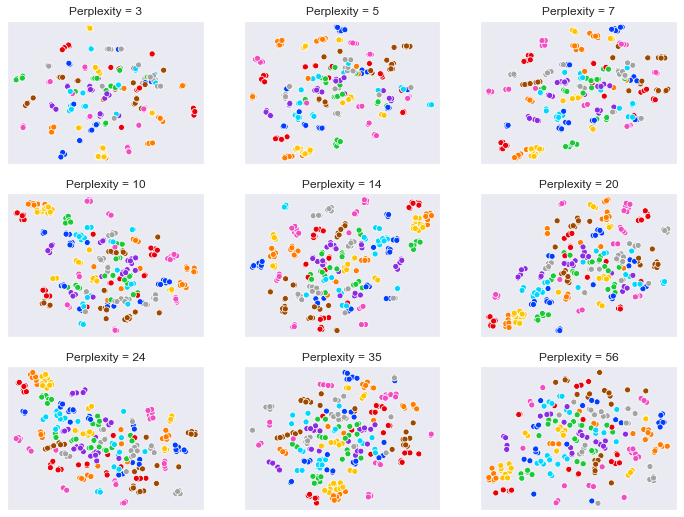

In [ ]:
sns.set_palette("bright")
fig = plt.figure()

# let's try various perplexity values
perp = [3, 5, 7, 10, 14, 20, 24, 35, 56]

for i, value in enumerate(perp):
    ax = fig.add_subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
        
    t_sne = TSNE(perplexity=value, n_jobs=-1)
    X_train_pca_sne = t_sne.fit_transform(X_train_pca)
        
    sns.scatterplot(X_train_pca_sne[: , 0], X_train_pca_sne[: , 1], hue=y_train, palette=sns.color_palette('bright', 40), legend=False);
    plt.title('Perplexity = ' + str(value))

Looks like there are no distinctive clusters in the data (or there are too many). Let's use the K-Means clustering and try to choose the best number of clusters using the silhouette score and inertia.

## Detecting the Optimal Number of Clusters Using Silhouette Score

In [ ]:
k_list = []
sil_score_list = []    

for k in range (10, 200):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    k_list.append(k)
    sil_score_list.append(silhouette_score(X_train, kmeans.labels_))

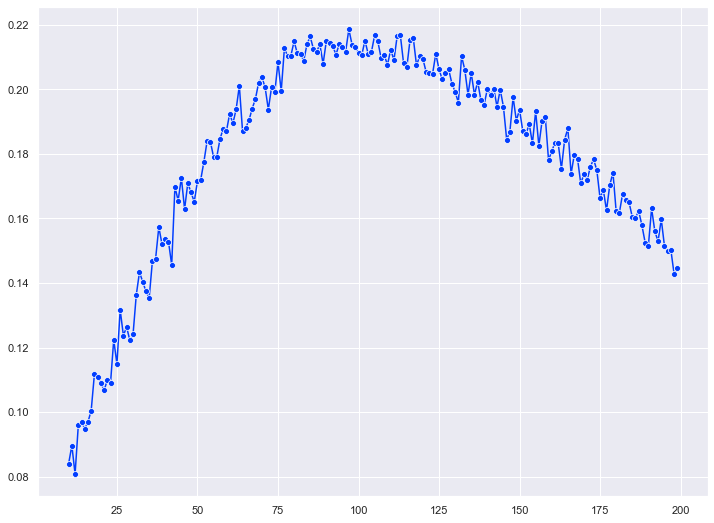

In [ ]:
sns.lineplot(k_list, sil_score_list, style=0, markers=True, legend=False);

In [ ]:
# # Alternative solution
# k_models = [KMeans(n_clusters=k, n_jobs = -1).fit(X_train) for k in range (20, 100)]
# silhoette_scores = [silhouette_score(X_train, model.labels_) for model in k_models]
# sns.lineplot(range (20, 100), silhoette_scores)

So let's detect k with best silhoette scores.

In [ ]:
sorted(zip(k_list, sil_score_list), key = lambda x:x[1], reverse=True)[0:15]

[(97, 0.21862341),
 (105, 0.21673676),
 (113, 0.21670368),
 (112, 0.21648884),
 (85, 0.21639574),
 (117, 0.21595453),
 (116, 0.21535137),
 (102, 0.21509857),
 (90, 0.2149485),
 (80, 0.2148937),
 (106, 0.21487552),
 (91, 0.21431108),
 (88, 0.21397465),
 (84, 0.21396875),
 (94, 0.21393068)]

In this particular case, the silhouette score method suggests that the number of clusters should be at least 90. It means that on average each cluster will contain few images (which is not good). So let's try to detect the optimal number of clusters using inertia.

## Detecting the Number of Clusters Using Inertia

In [ ]:
k_list = []
inertia_list = []    

for k in range (10, 200):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    k_list.append(k)
    inertia_list.append(kmeans.inertia_)

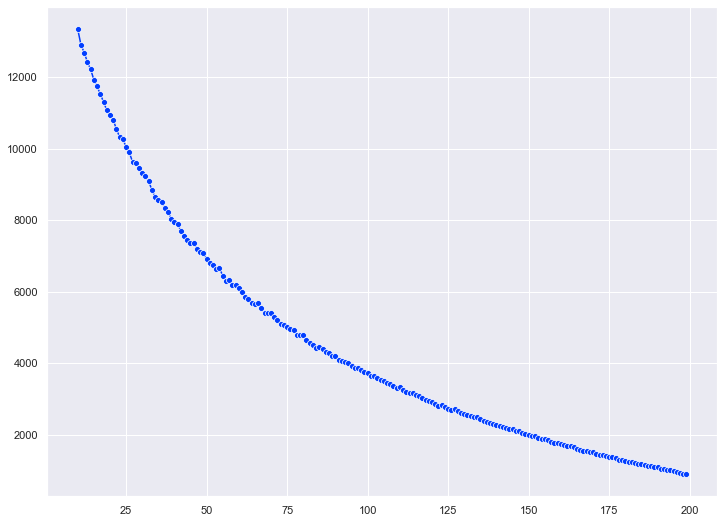

In [ ]:
sns.lineplot(k_list, inertia_list, style=0, markers=True, legend=False);

Unfortunately, we do not see the elbow on the graph. If we use the highest silhoette score for choosing the optimal number of clusters, we will get clusters with only a couple of images each. 

## Clustering Using K-Means

Thereby, let's choose k that is not too large, but with a reasonable score. For example, let's start with k = 60.

In [ ]:
kmeans = KMeans(n_clusters=60)
X_train_dist = kmeans.fit_transform(X_train)

In [ ]:
# here we get the list of distances to each of 60 clusters for each instance
X_train_dist.shape

(280, 60)

Now, for each cluster, let's detect the closest instance.

In [ ]:
# argmin returns the index of the image closest to each cluster
closest_image_idx = np.argmin(X_train_dist, axis=0)
closest_image = X_train[closest_image_idx]

Let's view the images that are closest to each cluster center.

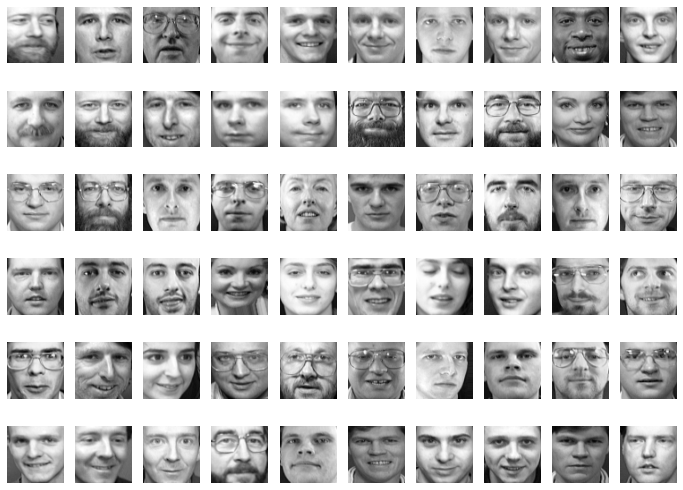

In [ ]:
k = 60
fig.subplots_adjust(wspace=0, hspace=0)
# plt.figure(figsize=(12, 15))
for index, closest_img in enumerate(closest_image):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(closest_img.reshape(64, 64), cmap=mpl.cm.gray, interpolation="bilinear")
    plt.axis('off')

plt.show()

Let's visualize some clusters.

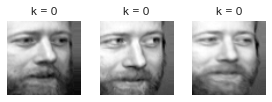

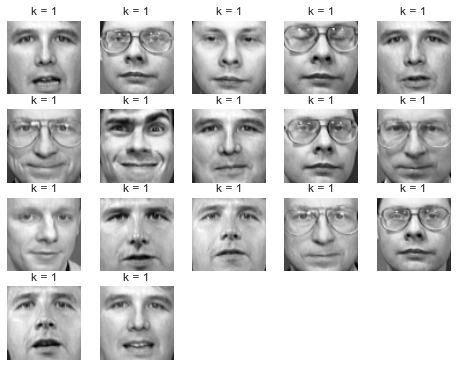

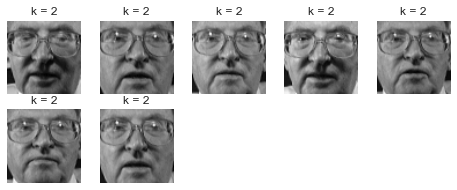

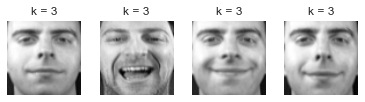

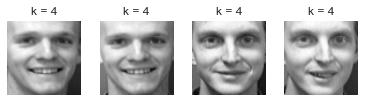

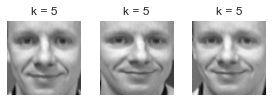

In [ ]:
for k in [0, 1, 2, 3, 4, 5]:
    X_train_k = X_train[kmeans.labels_ == k]
    plt.figure(figsize=(8, 16))
    for index, closest_img in enumerate(X_train_k):
        plt.subplot(10, 5, index + 1)
        plt.imshow(closest_img.reshape(64, 64), cmap=mpl.cm.gray, interpolation="bilinear")
        plt.title("k = " + str(k))
        plt.axis('off')
    plt.show()

We see that images in each cluster mostly belong to the same person.

# Etude 2 - Using Clustering with Classifiers

Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set. Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?

Let's train several classifiers on the tranining set and then evaluate them on the validation set.

## Classifying

### Classifiying Using KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knc = KNeighborsClassifier(n_jobs=-1)
knc.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [ ]:
knc.score(X_validate, y_validate)

0.8333333333333334

With default parameters, we obtain the 83% accuracy. Let's try the SVM classifier.

### Classifiying Using SVC

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(gamma='scale')
svc.fit(X_train, y_train)

SVC()

In [ ]:
svc.score(X_validate, y_validate)

0.9333333333333333

We achieved the ~93% accuracy on the validation set. Let's try the logistic regression.

### Classifying Using Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, n_jobs=-1)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', n_jobs=-1)

In [ ]:
log_reg.score(X_validate, y_validate)

0.95

We achieved the ~95% accuracy.

## Training on the Reduced Dataset

Let's traing the classifiers on the reduced (clustered) dataset.

### Training the SVC Classifier on the Reduced Dataset

Let's train the SVC classifier on the clustered dataset.

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion

In [ ]:
ppl = Pipeline([
    ('kmeans', kmeans),
    ('svc', svc)])

In [ ]:
gs_params = {
    'kmeans__n_clusters': range(30, 120)
}

In [ ]:
gs = GridSearchCV(ppl, gs_params, n_jobs=-1, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=60)),
                                       ('svc', SVC())]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(30, 120)})

In [ ]:
gs.score(X_validate, y_validate)

0.7166666666666667

In [ ]:
gs.best_params_

{'kmeans__n_clusters': 117}

### Training the Logistic Regression Classifier on the Reduced Dataset

Let's train the logistic regression classifier on the clustered dataset.

In [ ]:
ppl = Pipeline([
    ('kmeans', kmeans),
    ('log_reg', log_reg)])

gs_params = {
    'kmeans__n_clusters': range(30, 120)
}

In [ ]:
gs = GridSearchCV(ppl, gs_params, n_jobs=-1, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=60)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           n_jobs=-1))]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(30, 120)})

In [ ]:
gs.score(X_validate, y_validate)

0.9666666666666667

In [ ]:
gs.best_params_

{'kmeans__n_clusters': 108}

The application of the KMeans clustering algorithm improved the accuracy by 1.5% when used with logistic regression.

## Training on the Extended Dataset

### Training the SVC Again on the Extended (with KMeans) Features 

Let's try to append the features from the obtained dataset to the original dataset and train the classifiers again. Let's start with SVC.

In [ ]:
from sklearn.preprocessing import FunctionTransformer
data_passer = FunctionTransformer(lambda X: X, validate=False)

In [ ]:
combined_features = FeatureUnion([('kmeans', kmeans), ('data_passer', data_passer)])

In [ ]:
ppl2 = Pipeline([
    ('combined_features', combined_features),
    ('svc', svc)])

In [ ]:
gs_params2 = {
    'combined_features__kmeans__n_clusters' : range(30, 120)
}

In [ ]:
gs2 = GridSearchCV(ppl2, gs_params2, n_jobs=-1, cv=3)
gs2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        FeatureUnion(transformer_list=[('kmeans',
                                                                        KMeans(n_clusters=60)),
                                                                       ('data_passer',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002B07158C678>))])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'combined_features__kmeans__n_clusters': range(30, 120)})

In [ ]:
gs2.score(X_validate, y_validate)

0.65

In [ ]:
gs2.best_params_

{'combined_features__kmeans__n_clusters': 34}

The result actually got worse. Let's do the same for the logistic regression.

### Training the Logistic Regression Classifier Again on the Extended (with KMeans) Features 

In [ ]:
ppl2 = Pipeline([
    ('combined_features', combined_features),
    ('log_reg', log_reg)])

In [ ]:
gs_params2 = {
    'combined_features__kmeans__n_clusters' : range(30, 120)
}

In [ ]:
gs2 = GridSearchCV(ppl2, gs_params2, n_jobs=-1, cv=3)
gs2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        FeatureUnion(transformer_list=[('kmeans',
                                                                        KMeans(n_clusters=60)),
                                                                       ('data_passer',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002B07158C678>))])),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'combined_features__kmeans__n_clusters': range(30, 120)})

In [ ]:
gs2.score(X_validate, y_validate)

0.95

In [ ]:
gs2.best_params_

{'combined_features__kmeans__n_clusters': 31}

The result is better than in the previous case, but it did not achieve the accuracy of the logistic regression classifier with KMeans.

## Conclusion

So, clustering of the dataset indeed allowed us to reach the maximum accuracy (with logistic regression) -we achieved ~ 96% accuracy. However, it is only ~ 1% better that when using the LR alone. However, clustering not always helps - for example, it reduced the accuracy for SVC for staggering 22%. The usage of the extended dataset (Kmeans + Original) did not help either - we achieved the slightly lower accuracy for LR (~ 95%) and considerably lower accuracy for SVC - ~ 65% only.
We can conclude that, in our case, using the LR with clustering or alone would produce the best result.

# Etude 3 - Gaussian Mixture Models

Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset’s dimensionality (e.g., use PCA, preserving 99% of the variance). Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse_transform() method). Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

We also need to specify the number of clusters for the BGM. Using the information obtained from a previous section, we can be pretty sure that 90 is enough.

In [ ]:
pca = PCA(n_components=0.99)
gmm = BayesianGaussianMixture(n_components=90, n_init=10, random_state=42)

In [ ]:
gmm_pipeline = Pipeline([
    ('pca', pca),
    ('gmm', gmm)
])

In [ ]:
gmm_pipeline.fit(X_train)

Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('gmm',
                 BayesianGaussianMixture(n_components=90, n_init=10,
                                         random_state=42))])

Let's see the number of clusters actually used by GMM.

In [ ]:
len(np.where(np.round(gmm.weights_, 2) > 0)[0])

74

We see that 16 clusters can be considered unneseccary.

Now let's generate, for example, 16 faces.

In [ ]:
X_generated_inv, y_generated = gmm.sample(16)

In [ ]:
# since we applied PCA to our data, we should use 
# the inverse_transform function to reverse the transformation
X_generated = pca.inverse_transform(X_generated_inv)

Let's visualize the generated faces.

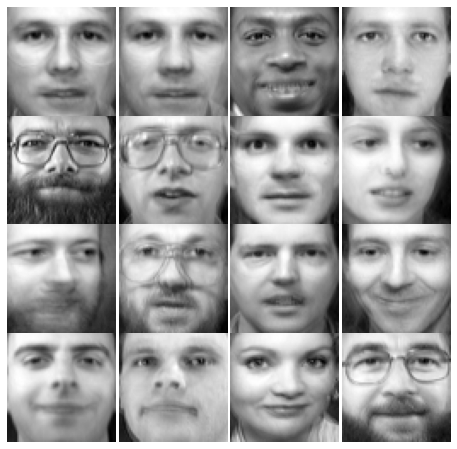

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(len(X_generated)):
    fig.add_subplot(4,4,i+1)
    plt.imshow(X_generated[i, :].reshape(64,64), cmap = mpl.cm.gray)
    plt.axis("off")

Let's see the densitities for the generated samples.

In [ ]:
gmm.score_samples(pca.transform(X_generated))

array([375.46448595, 367.04243256, 355.71208532, 339.43843805,
       370.95101677, 360.42134889, 380.77103488, 347.18145704,
       357.66322553, 358.12077753, 358.35554439, 345.92053999,
       361.18420066, 357.64011051, 365.09537879, 358.84213036])

Let's flip the first and third generated images.

In [ ]:
from scipy.ndimage.interpolation import rotate

In [ ]:
# transform each image into 64*64 matrix; otherwise, the rotate method cannot be applied
X_generated = X_generated.reshape(-1, 64, 64)

# rotating images 1 and 3 (15 degrees each)
for i in [0, 2]:
    X_generated[i] = rotate(X_generated[i], 15, reshape = False)

# reshaping the rotated images back
X_generated = X_generated.reshape(16, -1)

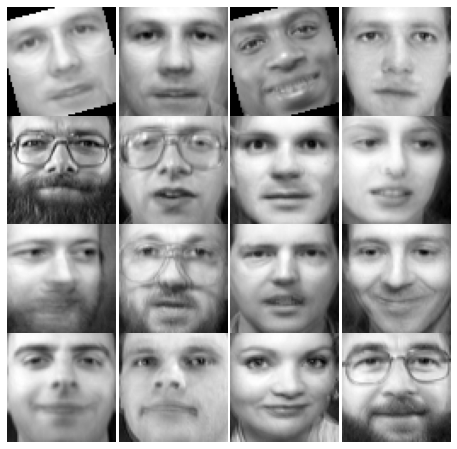

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(len(X_generated)):
    fig.add_subplot(4,4,i+1)
    plt.imshow(X_generated[i, :].reshape(64, 64), cmap = mpl.cm.gray)
    plt.axis("off")

Now let's check the densitities again.

In [ ]:
gmm.score_samples(pca.transform(X_generated))

array([-49849.53614442,    367.04243256, -37151.70387569,    339.43843805,
          370.95101677,    360.42134889,    380.77103488,    347.18145704,
          357.66322553,    358.12077753,    358.35554439,    345.92053999,
          361.18420066,    357.64011051,    365.09537879,    358.84213036])

Let's check whether the flipped images will be detected as anomalies.

In [ ]:
densities = gmm.score_samples(pca.transform(X_generated))
density_threshold = np.percentile(densities, 10)
anomalies = np.where(gmm.score_samples(pca.transform(X_generated)) < density_threshold)

In [ ]:
anomalies

(array([0, 2], dtype=int64),)

The algorithm indeed detected that the anomalies are images 1 and 3.

# Etude 4 - Anomaly Detection

Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.

Let's reduce the traning data and compute the reconstruction error.

In [ ]:
X_reduced = pca.fit_transform(X_train)
X_reconstruction = pca.inverse_transform(X_reduced)

The reconstruction error for the entire training dataset is as follows:

In [ ]:
from sklearn.metrics import mean_squared_error
rec_error = mean_squared_error(X_train, X_reconstruction)
rec_error

0.00019015337

Let's reconstruct the generated dataset.

In [ ]:
X_reduced_gen = pca.transform(X_generated)
X_reconstruction_gen = pca.inverse_transform(X_reduced_gen)

Let's plot the reconstructed images.

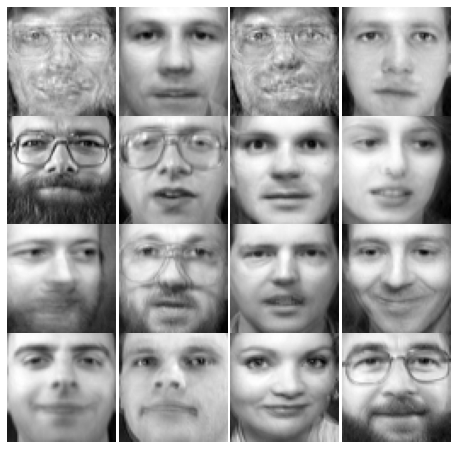

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(len(X_generated)):
    fig.add_subplot(4,4,i+1)
    plt.imshow(X_reconstruction_gen[i, :].reshape(64, 64), cmap = mpl.cm.gray)
    plt.axis("off")

Now let's compute the reconstruction error for the generated dataset.

In [ ]:
mse = []
for i in range(len(X_generated)):
    mse.append(mean_squared_error(X_generated[i], X_reconstruction_gen[i]))

In [ ]:
list(np.round(mse, 3))

[0.011,
 0.0,
 0.009,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

To obtain the indices of modified images, we find the MSEs larger than the reconstruction error obtained for the training data.

In [ ]:
anomalies2 = np.where(np.array(mse) > rec_error)
anomalies2

(array([0, 2], dtype=int64),)

Again, we see that in the generated dataset, images 1 and 3 are detected as anomalies. 